# 03 - Creación y entrenamiento de una red neuronal con Tensorflow


![tensorflow](../images/tensorflow.jpeg)

### Primero un poco de teoría

![node](../images/node.png)


![neural](../images/neural.jpg)

### Convolucionales

https://en.wikipedia.org/wiki/Convolution


![neural2](../images/neural2.webp)

![neural3](../images/neural3.gif)

![neural4](../images/neural4.png)


https://towardsdatascience.com/a-comprehensible-explanation-of-the-dimensions-in-cnns-841dba49df5e

# Entrenamiento del modelo (ajuste)

In [1]:
# librerias
import warnings
warnings.filterwarnings('ignore')

import numpy as np

from keras.preprocessing.image import ImageDataGenerator

from keras.applications import MobileNetV2  # red preentrenada

from keras.applications.mobilenet_v2 import preprocess_input

from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input

from keras.models import Model

from keras.optimizers.legacy import Adam


from keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical


from imutils import paths
import visualkeras
from IPython.display import Image

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report as report
import datetime

**Cargando y preparando datos**

In [2]:
imagenes=list(paths.list_images('../data/dataset_mascara'))

In [3]:
imagenes[0]

'../data/dataset_mascara/con_mascara/0_0_0 copy 4 2.jpg'

In [4]:
Image(url=imagenes[0], width=300)

In [5]:
# preparando datos

data=[]
etiquetas=[]

for img in imagenes:
    
    # etiqueta segun nombre del archivo
    if 'con_' in img:
        etiquetas.append([0])  # con tema
    else:
        etiquetas.append([1])  # sin tema
    
    
    # carga la imagen (224x224) y procesala
    imagen=load_img(img, target_size=(224, 224))
    imagen=img_to_array(imagen)
    imagen=preprocess_input(imagen)

    # añade a la lista
    data.append(imagen)
    

    
# se convierten datos y etiquetas a arrays de numpy
data=np.array(data, dtype='float32')
etiquetas=np.array(etiquetas)

In [6]:
data[0].shape

(224, 224, 3)

In [7]:
etiquetas[0]

array([0])

In [8]:
# one hot para las etiquetas

etiquetas=to_categorical(etiquetas)

etiquetas[0]

array([1., 0.], dtype=float32)

In [9]:
# train-test split (separa datos de entrenamiento y testeo)

X_train, X_test, y_train, y_test=tts(data, 
                                     etiquetas, 
                                     test_size=.2, 
                                     stratify=etiquetas, 
                                     random_state=42)

In [10]:
X_train.shape

(3076, 224, 224, 3)

In [11]:
# aumenta datos con el generador de imagenes

img_gen=ImageDataGenerator(rotation_range=20, 
                           zoom_range=.15,
                           width_shift_range=.2, 
                           height_shift_range=.2,
                           shear_range=.15, 
                           horizontal_flip=True,
                           fill_mode='nearest')

## Modelo - Red Neuronal

Se creara el modelo con MobileNetV2, una red para reconocimiento de imagenes preentrenada.

**constantes**

In [12]:
TASA=1e-4    # tasa de aprendizaje

EPOCAS=5     # epocas de entrenamiento

BATCH=32     # tamaño del batch (muestra de datos que pasan a la red para entrenar)

**Red**

In [13]:
# se carga MobileNetV2 sin el clasificador
modelo_base=MobileNetV2(weights='imagenet', 
                        include_top=False, 
                        input_tensor=Input(shape=(224, 224, 3)))


# se contruye el nuevo clasificador
modelo_x=modelo_base.output

modelo_x=AveragePooling2D(pool_size=(7, 7))(modelo_x)

modelo_x=Flatten(name='flatten')(modelo_x)

modelo_x=Dense(128, activation='relu')(modelo_x)

modelo_x=Dropout(.5)(modelo_x)

modelo_x=Dense(2, activation='softmax')(modelo_x)



# se pone todo junto
modelo=Model(inputs=modelo_base.input, outputs=modelo_x)

In [14]:
# se congela el entrenamiento del modelo base, aprovechamos el preentreno

for capa in modelo_base.layers:
    capa.trainable=False

In [15]:
# se compila el modelo

optimizador=Adam(lr=TASA, 
                 decay=TASA / EPOCAS)

modelo.compile(loss='binary_crossentropy', 
               optimizer=optimizador, 
               metrics=['accuracy'])

In [16]:
modelo.summary() # resumen de la red

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

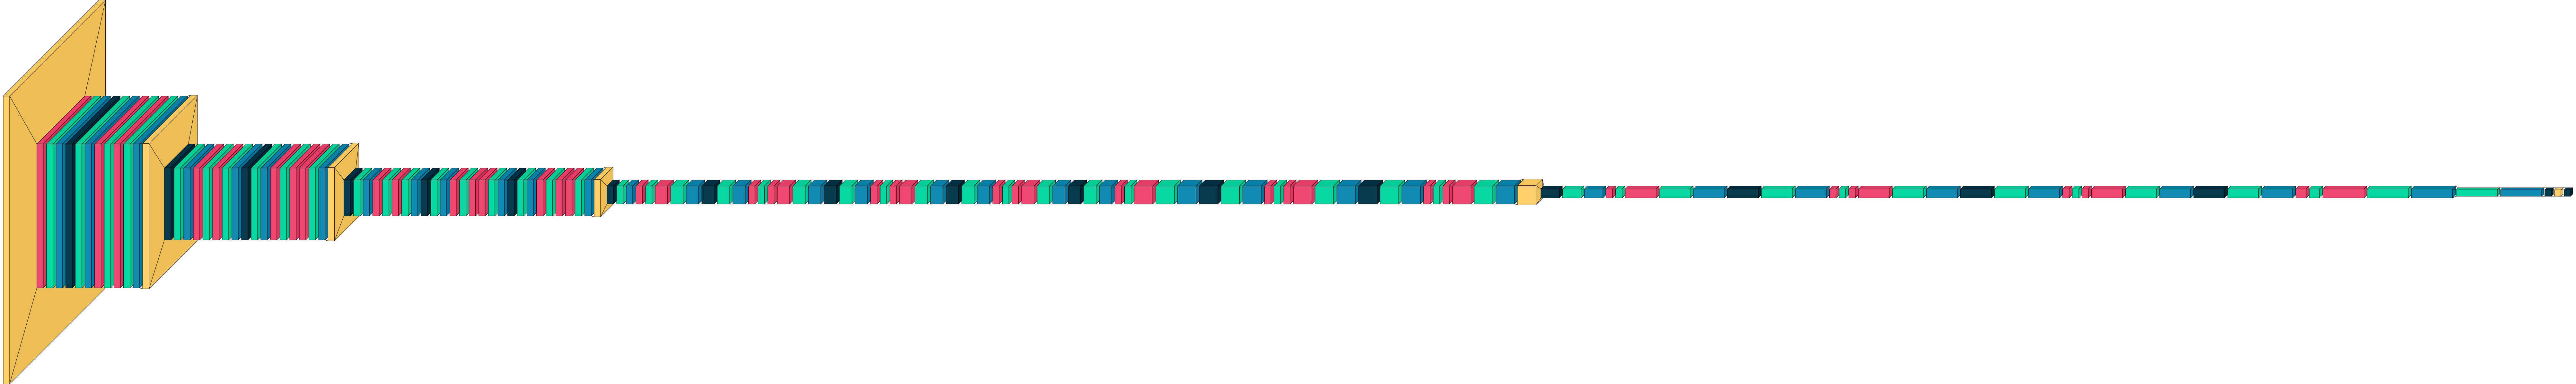

In [17]:
visualkeras.layered_view(modelo)

In [18]:
%%time

# se entrena el clasificador con las imagenes

print('Entrenando modelo...')

historico=modelo.fit(img_gen.flow(X_train, y_train, batch_size=BATCH), 
                     steps_per_epoch=len(X_train)//BATCH,
                     validation_data=(X_test, y_test), 
                     validation_steps=len(X_test)//BATCH, 
                     epochs=EPOCAS)

print('Entrenado.')

Entrenando modelo...
Epoch 1/5
96/96 [==============================] - 207s 2s/step - loss: 0.4160 - accuracy: 0.8407 - val_loss: 0.1622 - val_accuracy: 0.9740
Epoch 2/5
96/96 [==============================] - 194s 2s/step - loss: 0.1473 - accuracy: 0.9655 - val_loss: 0.0925 - val_accuracy: 0.9857
Epoch 3/5
96/96 [==============================] - 209s 2s/step - loss: 0.1003 - accuracy: 0.9754 - val_loss: 0.0721 - val_accuracy: 0.9857
Epoch 4/5
96/96 [==============================] - 177s 2s/step - loss: 0.0813 - accuracy: 0.9780 - val_loss: 0.0647 - val_accuracy: 0.9883
Epoch 5/5
96/96 [==============================] - 101s 1s/step - loss: 0.0718 - accuracy: 0.9780 - val_loss: 0.0583 - val_accuracy: 0.9870
Entrenado.
CPU times: user 18min 55s, sys: 3min 7s, total: 22min 3s
Wall time: 15min 15s


In [19]:
# haciendo predicciones
preds=modelo.predict(X_test, batch_size=BATCH)

preds[0]  # en probabilidad

25/25 [==============================] - 18s 710ms/step


array([9.9999952e-01, 5.2646186e-07], dtype=float32)

In [20]:
# la mayor prob de pertenencia, en 0/1

preds=np.argmax(preds, axis=1)

preds[0]  

0

In [21]:
# informe de clasificacion

print(report(y_test.argmax(axis=1), preds, target_names=['con_', 'sin_']))

              precision    recall  f1-score   support

        con_       0.99      0.98      0.99       384
        sin_       0.98      0.99      0.99       386

    accuracy                           0.99       770
   macro avg       0.99      0.99      0.99       770
weighted avg       0.99      0.99      0.99       770



In [22]:
# guardando modelo en formato h5

modelo.save(f'model/mascara.h5')
